# Korrelationsanalyse - Abstimmungsvariablen

Analyse der Korrelationen zwischen den numerischen Variablen in den Abstimmungsdaten.

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Paths
DB_PATH = Path('../../data/processed/swiss_votings.db')
OUTPUT_DIR = Path('.')

# Style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['font.size'] = 10

In [2]:
# Load voting data
conn = sqlite3.connect(DB_PATH)

df = pd.read_sql_query("""
    SELECT
        CAST(vr.geo_id AS INTEGER) as bfs_nr,
        vr.geo_name,
        v.voting_date,
        vr.proposal_id,
        p.title_de,
        vr.ja_stimmen_absolut,
        vr.nein_stimmen_absolut,
        vr.gueltige_stimmen,
        vr.eingelegte_stimmzettel,
        vr.anzahl_stimmberechtigte,
        vr.ja_stimmen_prozent as ja_prozent,
        vr.stimmbeteiligung_prozent as stimmbeteiligung
    FROM voting_results vr
    JOIN proposals p ON vr.proposal_id = p.proposal_id
    JOIN votings v ON p.voting_id = v.voting_id
    WHERE CAST(vr.geo_id AS INTEGER) > 100
    AND CAST(vr.geo_id AS INTEGER) < 9000
    AND vr.geo_name NOT LIKE 'Bezirk%'
    AND vr.geo_name NOT LIKE 'Kanton%'
""", conn)

print(f"Geladene Datensaetze: {len(df):,}")
print(f"Abstimmungen: {df['proposal_id'].nunique()}")
print(f"Gemeinden: {df['bfs_nr'].nunique()}")
df.head()

Geladene Datensaetze: 469,521
Abstimmungen: 223
Gemeinden: 2081


,bfs_nr,geo_name,voting_date,proposal_id,title_de,ja_stimmen_absolut,nein_stimmen_absolut,gueltige_stimmen,eingelegte_stimmzettel,anzahl_stimmberechtigte,ja_prozent,stimmbeteiligung
0,101,Steinmaur,20000312,1,Bundesbeschluss über die Justizreform,706,82,788,812,1885,89.593909,43.076923
1,102,Weiach,20000312,1,Bundesbeschluss über die Justizreform,266,56,322,340,677,82.608696,50.221566
2,111,Bäretswil,20000312,1,Bundesbeschluss über die Justizreform,1085,169,1254,1332,2864,86.523126,46.508380
3,112,Bubikon,20000312,1,Bundesbeschluss über die Justizreform,1477,164,1641,1740,3735,90.006094,46.586345
4,113,Dürnten,20000312,1,Bundesbeschluss über die Justizreform,1489,211,1700,1834,3982,87.588235,46.057258


## 1. Korrelationsmatrix der Abstimmungsvariablen

In [3]:
# Select numeric columns for correlation
numeric_cols = ['ja_stimmen_absolut', 'nein_stimmen_absolut', 'gueltige_stimmen',
                'eingelegte_stimmzettel', 'anzahl_stimmberechtigte',
                'ja_prozent', 'stimmbeteiligung']

df_numeric = df[numeric_cols].dropna()

# Calculate correlation matrix
corr_matrix = df_numeric.corr()

# Rename for better display
display_names = {
    'ja_stimmen_absolut': 'Ja (absolut)',
    'nein_stimmen_absolut': 'Nein (absolut)',
    'gueltige_stimmen': 'Gueltig',
    'eingelegte_stimmzettel': 'Eingelegte',
    'anzahl_stimmberechtigte': 'Stimmberechtigte',
    'ja_prozent': 'Ja %',
    'stimmbeteiligung': 'Beteiligung %'
}
corr_matrix_display = corr_matrix.rename(index=display_names, columns=display_names)

print("Korrelationsmatrix:")
corr_matrix_display.round(3)

Korrelationsmatrix:


,Ja (absolut),Nein (absolut),Gueltig,Eingelegte,Stimmberechtigte,Ja %,Beteiligung %
Ja (absolut),1.000,0.751,0.933,0.933,0.924,0.112,0.033
Nein (absolut),0.751,1.000,0.938,0.938,0.920,-0.071,0.041
Gueltig,0.933,0.938,1.000,1.000,0.986,0.020,0.040
Eingelegte,0.933,0.938,1.000,1.000,0.986,0.020,0.040
Stimmberechtigte,0.924,0.920,0.986,0.986,1.000,0.024,-0.007
Ja %,0.112,-0.071,0.020,0.020,0.024,1.000,-0.041
Beteiligung %,0.033,0.041,0.040,0.040,-0.007,-0.041,1.000


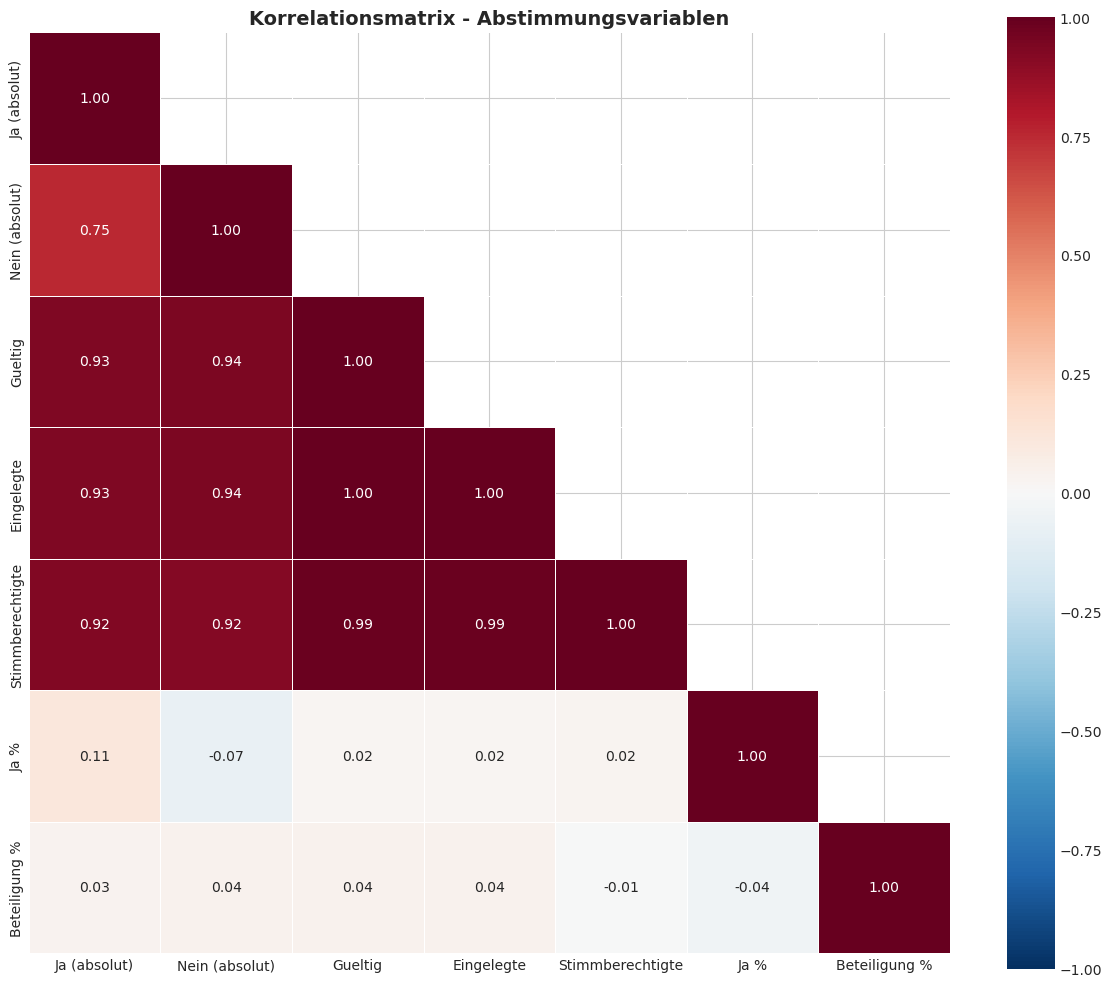

Gespeichert: correlation_voting_variables.png


In [4]:
# Heatmap
fig, ax = plt.subplots(figsize=(12, 10))

mask = np.triu(np.ones_like(corr_matrix_display, dtype=bool), k=1)

sns.heatmap(corr_matrix_display, 
            mask=mask,
            annot=True, 
            fmt='.2f',
            cmap='RdBu_r',
            center=0,
            vmin=-1, vmax=1,
            square=True,
            linewidths=0.5,
            ax=ax)

ax.set_title('Korrelationsmatrix - Abstimmungsvariablen', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'correlation_voting_variables.png', dpi=150, bbox_inches='tight')
plt.show()

print("Gespeichert: correlation_voting_variables.png")

## 2. Interpretation der Korrelationen

In [5]:
# Extract significant correlations (excluding diagonal and trivial ones)
def get_top_correlations(corr_df, n=15):
    """Extract top n correlations from correlation matrix."""
    pairs = []
    for i in range(len(corr_df.columns)):
        for j in range(i+1, len(corr_df.columns)):
            col1, col2 = corr_df.columns[i], corr_df.columns[j]
            corr = corr_df.iloc[i, j]
            pairs.append({'Variable 1': col1, 'Variable 2': col2, 'Korrelation': corr})
    
    df_pairs = pd.DataFrame(pairs)
    df_pairs['abs_corr'] = df_pairs['Korrelation'].abs()
    df_pairs = df_pairs.sort_values('abs_corr', ascending=False).drop('abs_corr', axis=1)
    return df_pairs.head(n)

top_corrs = get_top_correlations(corr_matrix_display)
print("Top 15 Korrelationen:")
top_corrs

Top 15 Korrelationen:


,Variable 1,Variable 2,Korrelation
11,Gueltig,Eingelegte,0.999844
15,Eingelegte,Stimmberechtigte,0.985748
12,Gueltig,Stimmberechtigte,0.985556
6,Nein (absolut),Gueltig,0.938480
7,Nein (absolut),Eingelegte,0.937522
2,Ja (absolut),Eingelegte,0.933304
1,Ja (absolut),Gueltig,0.932574
3,Ja (absolut),Stimmberechtigte,0.923683
8,Nein (absolut),Stimmberechtigte,0.920474
0,Ja (absolut),Nein (absolut),0.750745


## 3. Korrelation Ja-Prozent vs. Stimmbeteiligung pro Abstimmung

In [6]:
# Calculate correlation between ja_prozent and stimmbeteiligung for each proposal
corr_by_proposal = df.groupby(['proposal_id', 'title_de']).apply(
    lambda x: x['ja_prozent'].corr(x['stimmbeteiligung'])
).reset_index()
corr_by_proposal.columns = ['proposal_id', 'title_de', 'correlation']
corr_by_proposal = corr_by_proposal.dropna().sort_values('correlation')

print(f"Abstimmungen mit negativer Korrelation (Beteiligung-Ja%): {(corr_by_proposal['correlation'] < 0).sum()}")
print(f"Abstimmungen mit positiver Korrelation: {(corr_by_proposal['correlation'] > 0).sum()}")
print(f"\nMittlere Korrelation: {corr_by_proposal['correlation'].mean():.3f}")

Abstimmungen mit negativer Korrelation (Beteiligung-Ja%): 109
Abstimmungen mit positiver Korrelation: 114

Mittlere Korrelation: 0.002


/tmp/ipykernel_119543/3314555548.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  corr_by_proposal = df.groupby(['proposal_id', 'title_de']).apply(


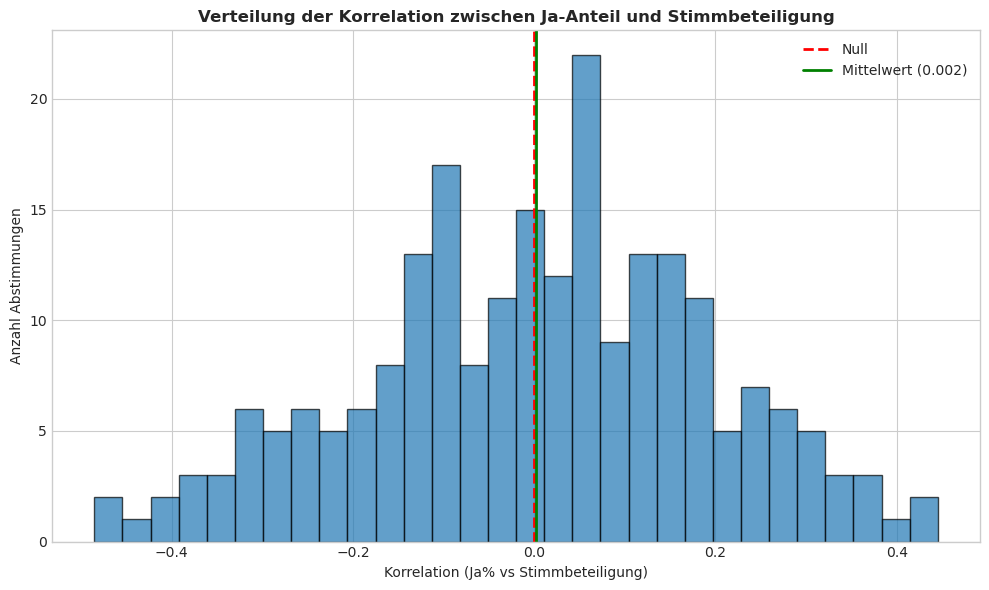

In [7]:
# Histogram of correlations
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(corr_by_proposal['correlation'], bins=30, edgecolor='black', alpha=0.7)
ax.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Null')
ax.axvline(x=corr_by_proposal['correlation'].mean(), color='green', linestyle='-', 
           linewidth=2, label=f'Mittelwert ({corr_by_proposal["correlation"].mean():.3f})')

ax.set_xlabel('Korrelation (Ja% vs Stimmbeteiligung)')
ax.set_ylabel('Anzahl Abstimmungen')
ax.set_title('Verteilung der Korrelation zwischen Ja-Anteil und Stimmbeteiligung', fontweight='bold')
ax.legend()

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'correlation_ja_beteiligung_distribution.png', dpi=150)
plt.show()

In [8]:
# Show extreme cases
print("\nAbstimmungen mit NEGATIVSTER Korrelation (hohe Beteiligung = weniger Ja):")
print(corr_by_proposal.head(5)[['title_de', 'correlation']].to_string(index=False))

print("\nAbstimmungen mit POSITIVSTER Korrelation (hohe Beteiligung = mehr Ja):")
print(corr_by_proposal.tail(5)[['title_de', 'correlation']].to_string(index=False))


Abstimmungen mit NEGATIVSTER Korrelation (hohe Beteiligung = weniger Ja):
                                                                                                                                          title_de  correlation
                                                                                                                 Bundesgesetz über die Raumplanung    -0.485216
                                                               Verfassungsartikel «Für Qualität und Wirtschaftlichkeit in der Krankenversicherung»    -0.456114
                                                      Volksinitiative «Stopp der Überbevölkerung - zur Sicherung der natürlichen Lebensgrundlagen»    -0.434552
                                                                                    Volksinitiative «Für eine Schweiz ohne synthetische Pestizide»    -0.409043
Volksinitiative «Für sauberes Trinkwasser und gesunde Nahrung – Keine Subventionen für den Pestizid- und den prophylaktischen

## 4. Scatter Plot - Beispielabstimmung

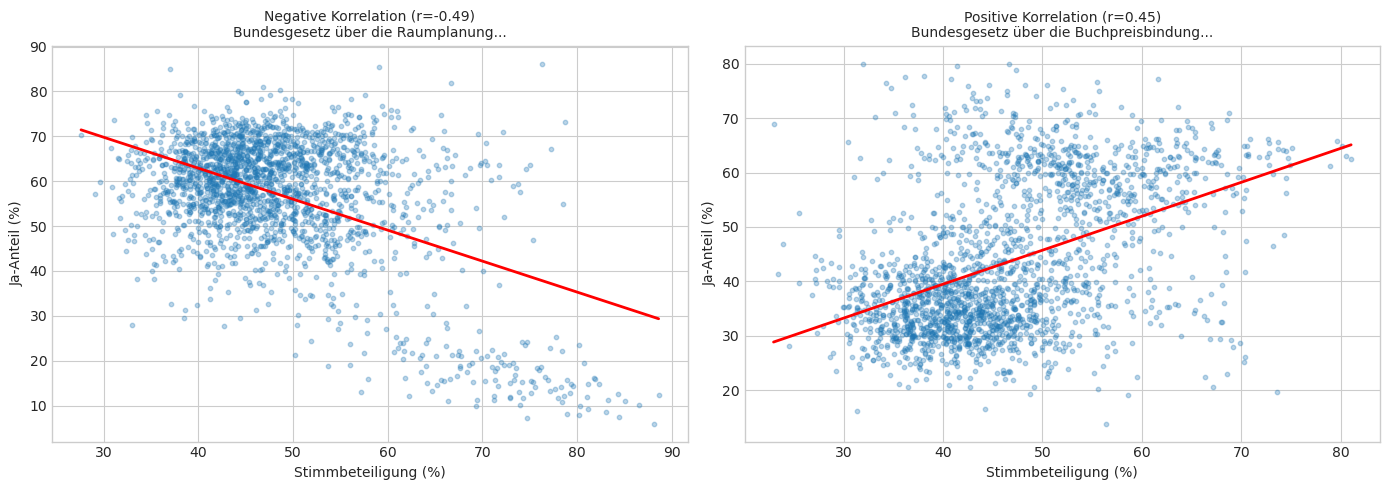

In [9]:
# Select one negative and one positive correlation example
neg_example = corr_by_proposal.iloc[0]
pos_example = corr_by_proposal.iloc[-1]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Negative correlation example
df_neg = df[df['proposal_id'] == neg_example['proposal_id']]
axes[0].scatter(df_neg['stimmbeteiligung'], df_neg['ja_prozent'], alpha=0.3, s=10)
z = np.polyfit(df_neg['stimmbeteiligung'].dropna(), df_neg['ja_prozent'].dropna(), 1)
p = np.poly1d(z)
x_line = np.linspace(df_neg['stimmbeteiligung'].min(), df_neg['stimmbeteiligung'].max(), 100)
axes[0].plot(x_line, p(x_line), 'r-', linewidth=2)
axes[0].set_xlabel('Stimmbeteiligung (%)')
axes[0].set_ylabel('Ja-Anteil (%)')
axes[0].set_title(f'Negative Korrelation (r={neg_example["correlation"]:.2f})\n{neg_example["title_de"][:50]}...', fontsize=10)

# Positive correlation example
df_pos = df[df['proposal_id'] == pos_example['proposal_id']]
axes[1].scatter(df_pos['stimmbeteiligung'], df_pos['ja_prozent'], alpha=0.3, s=10)
z = np.polyfit(df_pos['stimmbeteiligung'].dropna(), df_pos['ja_prozent'].dropna(), 1)
p = np.poly1d(z)
x_line = np.linspace(df_pos['stimmbeteiligung'].min(), df_pos['stimmbeteiligung'].max(), 100)
axes[1].plot(x_line, p(x_line), 'r-', linewidth=2)
axes[1].set_xlabel('Stimmbeteiligung (%)')
axes[1].set_ylabel('Ja-Anteil (%)')
axes[1].set_title(f'Positive Korrelation (r={pos_example["correlation"]:.2f})\n{pos_example["title_de"][:50]}...', fontsize=10)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'scatter_ja_vs_beteiligung_examples.png', dpi=150)
plt.show()

## 5. Zusammenfassung

In [10]:
print("="*70)
print("ZUSAMMENFASSUNG - KORRELATIONEN ABSTIMMUNGSVARIABLEN")
print("="*70)
print("\n1. TRIVIALE KORRELATIONEN (erwartungsgemaess hoch):")
print("   - Absolute Stimmenzahlen korrelieren stark mit Gemeindgroesse")
print("   - Ja + Nein = Gueltig (mathematische Beziehung)")
print("\n2. INTERESSANTE BEFUNDE:")
print(f"   - Korrelation Ja% vs Beteiligung variiert stark pro Abstimmung")
print(f"   - Mittelwert: {corr_by_proposal['correlation'].mean():.3f}")
print(f"   - Spannweite: {corr_by_proposal['correlation'].min():.3f} bis {corr_by_proposal['correlation'].max():.3f}")
print("\n3. INTERPRETATION:")
print("   - Bei kontroversen Themen mobilisieren beide Seiten unterschiedlich")
print("   - Hohe Beteiligung kann sowohl fuer als auch gegen Vorlage sprechen")
print("="*70)

# Save correlation data
corr_by_proposal.to_csv(OUTPUT_DIR / 'correlation_ja_beteiligung_by_proposal.csv', index=False)
print("\nGespeichert: correlation_ja_beteiligung_by_proposal.csv")

conn.close()

ZUSAMMENFASSUNG - KORRELATIONEN ABSTIMMUNGSVARIABLEN

1. TRIVIALE KORRELATIONEN (erwartungsgemaess hoch):
   - Absolute Stimmenzahlen korrelieren stark mit Gemeindgroesse
   - Ja + Nein = Gueltig (mathematische Beziehung)

2. INTERESSANTE BEFUNDE:
   - Korrelation Ja% vs Beteiligung variiert stark pro Abstimmung
   - Mittelwert: 0.002
   - Spannweite: -0.485 bis 0.445

3. INTERPRETATION:
   - Bei kontroversen Themen mobilisieren beide Seiten unterschiedlich
   - Hohe Beteiligung kann sowohl fuer als auch gegen Vorlage sprechen

Gespeichert: correlation_ja_beteiligung_by_proposal.csv
